**Steps:**
- Take 20220228_20220828 as test data
- Groupby merchant abn & month
- Transaction merge w/ consumer SA2
- Take the most common SA2 to be merchant SA2

**Features:**
1. _External Data:_
- Income by SA2 (median AUD income & median age income)
- Age population by SA2 (age 20 - 55)
2. _Internal Data:_ 
- Tags (one hot encoding)
- Transaction frequency
- Number of new consumers during the specified month
- Number of active days
- Average growth % Month to Month per merchant 
- Fraud likeliness (wait for Andrew)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.functions import sum, avg, count, lag, date_sub, split
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/05 00:07:42 WARN Utils: Your hostname, Patricks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 100.94.178.230 instead (on interface en0)
22/10/05 00:07:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/05 00:07:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/05 00:07:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# load data from ETL
df_trx_sa2 = spark.read.parquet('../data/curated/fin_df_trx_sa2.parquet')
df_trx_sa2_test = spark.read.parquet('../data/curated/fin_df_trx_sa2_test.parquet')

In [4]:
age = gpd.read_file("../data/abs/sa2_age.gml")
income = gpd.read_file("../data/abs/sa2_income.gml")

In [5]:
age.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 69 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gml_id               2288 non-null   object  
 1   sa2_main16           2288 non-null   int64   
 2   state_code           2288 non-null   int64   
 3   state_name           2288 non-null   object  
 4   gccsa_code16         2288 non-null   object  
 5   gccsa_name16         2288 non-null   object  
 6   sa4_code16           2288 non-null   int64   
 7   sa4_name16           2288 non-null   object  
 8   sa3_code16           2288 non-null   int64   
 9   sa3_name16           2288 non-null   object  
 10  sa2_name16           2288 non-null   object  
 11  females_age_0_4      2288 non-null   int64   
 12  females_age_10_14    2288 non-null   int64   
 13  females_age_15_19    2288 non-null   int64   
 14  females_age_20_24    2288 non-null   int64   
 15  females_age_2

In [6]:
df_trx_sa2 = (df_trx_sa2.withColumn("order_year_month", 
                                date_format(col("order_datetime"), 'yyyy-MM')))
df_trx_sa2_test = (df_trx_sa2_test.withColumn("order_year_month", 
                                date_format(col("order_datetime"), 'yyyy-MM')))

---

In [7]:
df_trx_sa2.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- revenue: float (nullable = true)
 |-- order_year_month: string (nullable = true)



In [8]:
df_trx_sa2_test.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- revenue: float (nullable = true)
 |-- order_year_month: string (nullable = true)



In [9]:
# df_trx_sa2.show(1, vertical=True)

In [10]:
# df_trx_sa2_test.show(1, vertical=True)

In [11]:
# calculate population of age above 20
def get_age_pop(age_start, age_end):
    '''
    Create new columns that sum the age population that is in the range of
    age_start and age_end from the age dataframe.
    '''
    
    left_age = age_start
    right_age = left_age + 4
    
    age[f'males_age_{age_start}_{age_end}'] = age[f'males_age_{left_age}_{right_age}']
    age[f'females_age_{age_start}_{age_end}'] = age[f'females_age_{left_age}_{right_age}']
    
    while right_age < age_end + 1:
        left_age += 5
        right_age += 5
        
        age[f'males_age_{age_start}_{age_end}'] += age[f'males_age_{left_age}_{right_age}']
        age[f'females_age_{age_start}_{age_end}'] += age[f'females_age_{left_age}_{right_age}']
    
    return age
        
    
age = get_age_pop(20, 44)
age = get_age_pop(45, 60)

age = age[['sa2_main16', 'males_age_20_44', 'females_age_20_44', 
           'males_age_45_60', 'females_age_45_60']]

# change age gpd dataframe to sdf
age_sdf = spark.createDataFrame(age)

# change income gpd dataframe to sdf
cols = ['sa2_code', 'median_age_of_earners_years', 'median_aud', 
        'gini_coefficient_coef']
income_sdf = spark.createDataFrame(income[cols])

# Feature Engineering

In [12]:
def get_cat_merchant_data(product_category, trx_data):
    '''
    Group and Aggregate consolidated data to be used for modelling
    '''

    df_cat = trx_data.filter(F.col('categories').isin(product_category))
    df_cat = df_cat.drop('consumer_name', 'address', 'geometry', 'sa2_code', 
                         'merchant_name', 'sa2_name_2016', 'postcode', 'state')

    # create new year-month column from date
    df_cat = (df_cat.withColumn("order_year_month", 
                                date_format(col("order_datetime"), 'yyyy-MM')
                    .alias("yyyy-MM")))

    # create new order month column from date
    df_cat = (df_cat.withColumn("order_month", 
                                date_format(col("order_datetime"), 'M')
                                .cast('INT')))


    ## consumer first transaction month
    w = Window.partitionBy('consumer_id')
    df_consumer_first = df_cat.withColumn('first_trx_date', F.min('order_datetime').over(w))\
                              .where(F.col('order_datetime') == F.col('first_trx_date')) \
                              .withColumn("first_trx_month", 
                                          date_format(col("order_datetime"), 
                                                      'yyyy-MM'))
    df_consumer_first = df_consumer_first[['consumer_id', 'first_trx_month']]
    df_cat = (df_cat \
                 .join(df_consumer_first, 
                       on=['consumer_id'], 
                       how='left') \
             )
    df_cat = df_cat.withColumn(
                                'is_consumer_first_trx',
                                F.when(
                                    (F.col('order_year_month') == 
                                     F.col("first_trx_month")), 1
                                ).otherwise(0)   
                              )


    ## take the most frequent consumer SA2 to be merchant SA2
    df_sa2_count = (df_cat.groupby(['merchant_abn', 'sa2_maincode_2016'])
                    .agg(F.count("sa2_maincode_2016").alias("count")))
    w = Window().partitionBy("merchant_abn").orderBy(F.desc("count"))
    df_with_rank = (df_sa2_count.withColumn("rank", F.dense_rank().over(w)))

    # get first row sa2 if ties exist
    df_merchant_sa2 = (df_with_rank.where(F.col("rank") == 1)
                       .dropDuplicates(subset = ['merchant_abn'])
                       .drop('Rank')
                       .drop('count')
                       .withColumnRenamed('sa2_maincode_2016', 'merchant_sa2'))

    # join merchant sa2 to trx data
    df_cat = (df_cat \
                 .join(df_merchant_sa2, 
                       on=['merchant_abn'], 
                       how='left')
             )

    ## Aggregate BNPL internal data
    # transaction frequency, # active days, # unique consumer, # new consumer
    # take rate, revenue (label), # possible merchant fraud trx,
    # # possible consumer fraud trx
    sdf = (df_cat.groupby(['merchant_abn', 'merchant_sa2', 'order_year_month', 
                           'order_month'])
                 .agg(count('order_id'),
                      countDistinct('order_datetime'),
                      countDistinct('consumer_id'),
                      sum('is_consumer_first_trx'),
                      avg('take_rate'),
                      sum('revenue'))
                      # sum('cons_possible_fraud'),
                      # sum('merc_possible_fraud'))
                 .withColumnRenamed("count(order_id)", 'trx_count')
                 .withColumnRenamed("count(order_datetime)", 
                                    'active_days')
                 .withColumnRenamed("count(consumer_id)", 
                                    'distinct_consumer')
                 .withColumnRenamed("sum(is_consumer_first_trx)", 
                                    'new_consumer')
                 .withColumnRenamed("avg(take_rate)", 
                                    'take_rate')
                 .withColumnRenamed("sum(revenue)", 
                                    'total_revenue'))
                 # .withColumnRenamed("sum(cons_possible_fraud)", 
                 #                    'n_trx_cons_possible_fraud')
                 # .withColumnRenamed("sum(merc_possible_fraud)", 
                 #                    'n_trx_merc_possible_fraud'))


    # calculate the average monthly growth
    df_cat_grouped = (df_cat.groupBy(["merchant_abn", 'order_year_month'])
                            .sum("dollar_value")
                            .sort(['merchant_abn', 'order_year_month']))

    win = Window.partitionBy("merchant_abn").orderBy('order_year_month')
    df_sales_diff = (df_cat_grouped.withColumn('sales_change', df_cat_grouped['sum(dollar_value)'] - lag(df_cat_grouped['sum(dollar_value)']).over(win))
                                   .withColumn('last_sales',F.lag(df_cat_grouped['sum(dollar_value)']).over(win))
                                   .withColumn('growth_perc', F.round((F.col('sales_change')/F.col('last_sales'))*100,2)))

    df_sales_growth = (df_sales_diff.groupby('merchant_abn')
                       .agg(avg('growth_perc'))
                       .withColumn("avg(growth_perc)", 
                                   F.round(F.col("avg(growth_perc)"), 2))
                       .withColumnRenamed('avg(growth_perc)', 'avg_monthly_growth'))
    df_sales_diff = (df_sales_diff.na.fill(value=0, subset=["growth_perc"]))

    # join MoM growth
    sdf = (sdf \
               .join(df_sales_diff[['merchant_abn', 'order_year_month', 
                                    'growth_perc']], 
                     on=['merchant_abn', 'order_year_month'], 
                     how='inner')
          )


    # join income by merchant_sa2
    sdf = (sdf \
                 .join(income_sdf, 
                       on=sdf['merchant_sa2'] == income_sdf['sa2_code'], 
                       how='left') \
                 .drop('sa2_code')
             )

    ## join age by merchant_sa2
    sdf = (sdf \
                 .join(age_sdf, 
                       on=[sdf['merchant_sa2'] == age_sdf['sa2_main16']], 
                       how='left') \
                 .drop('sa2_main16')
             )
    return sdf
    

# Product categories selection (3 categories)

In [13]:
pc_month = df_trx_sa2.groupby(['categories', 'order_year_month']).agg(count('order_id'), sum('revenue'))

In [14]:
pc_selection = (pc_month.groupby('categories')
                .agg(avg('sum(revenue)'))
                .withColumnRenamed('avg(sum(revenue))', 
                                   'monthly_average_revenue')
                .orderBy('monthly_average_revenue', ascending=False))

In [15]:
df_pc_selection = pc_selection.toPandas()

In [16]:
df_pc_selection.sort_values(by='monthly_average_revenue', ascending=False)

,categories,monthly_average_revenue
0,"gift, card, novelty, and souvenir shops",193722.312044
1,"computers, computer peripheral equipment, and ...",186973.917567
2,artist supply and craft shops,175762.473246
3,tent and awning shops,171418.513217
4,"computer programming , data processing, and in...",166879.150671
5,"florists supplies, nursery stock, and flowers",160913.314841
6,"books, periodicals, and newspapers",153402.852763
7,"digital goods: books, movies, music",147744.356488
8,motor vehicle supplies and new parts,142850.355956
9,shoe shops,142829.136314


In [17]:
technology = ['computers, computer peripheral equipment, and software',
              'computer programming , data processing, and integrated systems design services']

furniture = ['furniture, home furnishings and equipment shops, and manufacturers, except appliances',
             'equipment, tool, furniture, and appliance rent al and leasing']

hobby_toys = ['tent and awning shops', 'artist supply and craft shops', 
              'hobby, toy and game shops']

tech_sdf = get_cat_merchant_data(technology, df_trx_sa2)
furniture_sdf = get_cat_merchant_data(furniture, df_trx_sa2)
hobby_sdf = get_cat_merchant_data(hobby_toys, df_trx_sa2)

tech_sdf_test = get_cat_merchant_data(technology, df_trx_sa2_test)
furniture_sdf_test = get_cat_merchant_data(furniture, df_trx_sa2_test)
hobby_sdf_test = get_cat_merchant_data(hobby_toys, df_trx_sa2_test)



In [18]:
tech_df = tech_sdf.toPandas()
tech_df_test = tech_sdf_test.toPandas()

In [19]:
furniture_df = furniture_sdf.toPandas()
furniture_df_test = furniture_sdf_test.toPandas()

In [20]:
hobby_df = hobby_sdf.toPandas()
hobby_df_test = hobby_sdf_test.toPandas()

In [21]:
print(len(tech_df), len(furniture_df), len(hobby_df))
print(len(tech_df_test), len(furniture_df_test), len(hobby_df_test))

4511 3016 5696
3092 2088 3973


In [22]:
all_df = pd.concat([tech_df,furniture_df,hobby_df],axis=0)

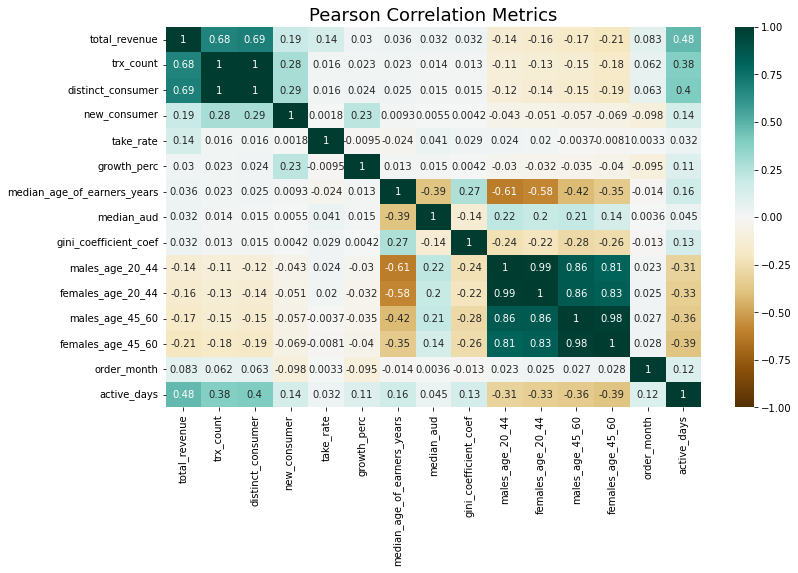

In [23]:
fields = ['total_revenue', 'trx_count', 'distinct_consumer', 'new_consumer', 
          'take_rate', 'growth_perc', 'median_age_of_earners_years', 
          'median_aud', 'gini_coefficient_coef', 'males_age_20_44', 
          'females_age_20_44', 'males_age_45_60', 'females_age_45_60',
          'order_month', 'active_days']
plt.figure(figsize=(12,7))
sns.heatmap(all_df[fields].corr(method='pearson'), 
            vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metrics', fontsize=18)
plt.show()

In [24]:
def fill_na_w_mean(df):
    '''
    Fill any na values in dataframe with the column mean
    '''
    for col in df.columns:
        if df[col].isna().sum() > 0:
            mean_value = df[col].mean()
            df[col].fillna(value=mean_value, inplace=True)

In [25]:
fill_na_w_mean(tech_df)
fill_na_w_mean(tech_df_test)
fill_na_w_mean(furniture_df)
fill_na_w_mean(furniture_df_test)
fill_na_w_mean(hobby_df)
fill_na_w_mean(hobby_df_test)

In [26]:
tech_df.to_csv('../data/curated/tech_df.csv')
furniture_df.to_csv('../data/curated/furniture_df.csv')
hobby_df.to_csv('../data/curated/hobby_df.csv')

tech_df_test.to_csv('../data/curated/tech_df_test.csv')
furniture_df_test.to_csv('../data/curated/furniture_df_test.csv')
hobby_df_test.to_csv('../data/curated/hobby_df_test.csv')

In [39]:
all_catg = df_pc_selection['categories'].values.tolist()

all_df = get_cat_merchant_data(all_catg, df_trx_sa2).toPandas()
all_df_test = get_cat_merchant_data(all_catg, df_trx_sa2_test).toPandas()

fill_na_w_mean(all_df)
fill_na_w_mean(all_df_test)

all_df.to_csv(f'../data/curated/all_df.csv')
all_df_test.to_csv(f'../data/curated/all_df_test.csv')

22/10/05 00:46:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:41 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/05 00:46:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:49 WARN RowBasedKeyValueBatch: Calling spill() on

[2350.190s][warning][gc,alloc] Executor task launch worker for task 3.0 in stage 614.0 (TID 751): Retried waiting for GCLocker too often allocating 8388610 words
22/10/05 00:46:51 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
22/10/05 00:46:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:46:59 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/05 00:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:26 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/05 00:47:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:47:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:47:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [38]:
# top_10_catg = df_pc_selection.sort_values(by='monthly_average_revenue', 
#                             ascending=False)['categories'].values.tolist()[:10]

# i = 0
# for cat in top_10_catg:
#     print(f'Uploading {cat}')
    
#     df = get_cat_merchant_data(top_10_catg, df_trx_sa2).toPandas()
#     df_test = get_cat_merchant_data(top_10_catg, df_trx_sa2_test).toPandas()
    
#     fill_na_w_mean(df)
#     fill_na_w_mean(df_test)

#     df.to_csv(f'../data/curated/{i}_df.csv')
#     df_test.to_csv(f'../data/curated/{i}_df_test.csv')

#     print(f'Successfully uploaded {cat}')
#     i += 1

Uploading gift, card, novelty, and souvenir shops


22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:40:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:38 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:40:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


ERROR:root:KeyboardInterrupt while sending command.][Stage 532:>  (0 + 0) / 4]4]
Traceback (most recent call last):
  File "/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/patrick/opt/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

22/10/05 00:41:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/05 00:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/05 00:41:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:684)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:650)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:626)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:583)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:540)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
